# Домашнее задание № 2

<pre>
ФИО: Никифоров Владимир
</pre>

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import xgboost
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
raw_df = pd.read_csv('../data/rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [6]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  394669
Total transactions in test dataset:  95844


### 1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test

In [7]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [8]:
agg_df = get_aggregated_df(raw_df, 'sum', 'MCC')

In [9]:
agg_df.head()

MCC,MCC_sum_742,MCC_sum_763,MCC_sum_780,MCC_sum_1520,MCC_sum_1711,MCC_sum_1731,MCC_sum_1750,MCC_sum_1799,MCC_sum_2741,MCC_sum_2842,...,MCC_sum_8699,MCC_sum_8911,MCC_sum_8931,MCC_sum_8999,MCC_sum_9211,MCC_sum_9222,MCC_sum_9311,MCC_sum_9399,MCC_sum_9402,MCC_sum_9405
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3825.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2400.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
agg_df = agg_df.reset_index()
agg_df.columns

Index(['cl_id', 'MCC_sum_742', 'MCC_sum_763', 'MCC_sum_780', 'MCC_sum_1520',
       'MCC_sum_1711', 'MCC_sum_1731', 'MCC_sum_1750', 'MCC_sum_1799',
       'MCC_sum_2741',
       ...
       'MCC_sum_8699', 'MCC_sum_8911', 'MCC_sum_8931', 'MCC_sum_8999',
       'MCC_sum_9211', 'MCC_sum_9222', 'MCC_sum_9311', 'MCC_sum_9399',
       'MCC_sum_9402', 'MCC_sum_9405'],
      dtype='object', name='MCC', length=345)

In [11]:
# create transactions dataset for train
transactions_train = agg_df[~agg_df.cl_id.isin(cl_ids_test)][['cl_id']].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = agg_df[agg_df.cl_id.isin(cl_ids_test)][['cl_id']].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [12]:
transactions_train['target_flag'] = transactions_train.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']]['target_flag']), axis=1)
transactions_train['channel_type'] = transactions_train.apply(lambda x: raw_df[raw_df['cl_id'] == x['cl_id']].groupby('cl_id')[['channel_type']].first().values[0][0], axis=1)
transactions_test['target_flag'] = transactions_test.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']]['target_flag']), axis=1)
transactions_test['channel_type'] = transactions_test.apply(lambda x: raw_df[raw_df['cl_id'] == x['cl_id']].groupby('cl_id')[['channel_type']].first().values[0][0], axis=1)

In [13]:
transactions_train.head()

MCC,cl_id,target_flag,channel_type
0,0,0,NaN
1,1,0,NaN
4,10,0,NaN
5,11,0,NaN
6,14,1,NaN


In [14]:
#При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:
#общая сумма транзакций по каждой из trx_category
for trx in list(raw_df.trx_category.unique()):
    raw_df['sum_trx_%s' % trx] = raw_df[(raw_df.trx_category == trx)].groupby('cl_id')['amount'].sum()    

In [15]:
#общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
print(raw_df.currency.value_counts().head(3))
for cur in list(raw_df.currency.value_counts().head(3).index): #list(raw_df.currency.unique()):
    raw_df['sum_cur_%s' % cur] = raw_df[(raw_df.currency == cur)].groupby('cl_id')['amount'].sum()

810    477644
978      5536
840      1921
Name: currency, dtype: int64


In [16]:
raw_df.MCC.value_counts()

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
5331      7641
4121      6266
5211      6262
4829      6205
5691      5161
5261      4803
4111      4362
5977      4300
5200      3460
5732      3271
5311      3258
5533      2946
5651      2915
4812      2857
5641      2710
8099      2674
5722      2667
5661      2601
8999      2599
5941      2597
         ...  
3064         1
3678         1
8675         1
3548         1
3607         1
3730         1
3029         1
3535         1
3722         1
7333         1
7339         1
3387         1
3715         1
3508         1
3640         1
3513         1
3515         1
3191         1
5937         1
3634         1
3520         1
7217         1
3659         1
3628         1
3778         1
5960         1
3625         1
7211         1
7631         1
3703         1
Name: MCC, Length: 344, dtype: int64

In [17]:
#общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test.
# Возьмем МСС top10
for mcc in list(raw_df.MCC.value_counts().head(10).index):
    raw_df['sum_mcc_%s' % mcc] = raw_df[(raw_df.MCC == mcc)].groupby('cl_id')['amount'].sum()

In [18]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,...,sum_mcc_5411,sum_mcc_6011,sum_mcc_5814,sum_mcc_5812,sum_mcc_5499,sum_mcc_5541,sum_mcc_5912,sum_mcc_5999,sum_mcc_6012,sum_mcc_5921
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,...,2031.00,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,36562.0,767.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,...,14629.46,145000.0,82441.17,3180.01,492.8,NaN,2441.0,675.0,NaN,NaN
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.

In [20]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 33 columns):
PERIOD                    490513 non-null object
cl_id                     490513 non-null int64
MCC                       490513 non-null int64
channel_type              487603 non-null object
currency                  490513 non-null int64
TRDATETIME                490513 non-null object
amount                    490513 non-null float64
trx_category              490513 non-null object
target_flag               490513 non-null int64
target_sum                490513 non-null float64
sum_trx_POS               5000 non-null float64
sum_trx_DEPOSIT           2864 non-null float64
sum_trx_C2C_OUT           1237 non-null float64
sum_trx_WD_ATM_ROS        2771 non-null float64
sum_trx_BACK_TRX          1439 non-null float64
sum_trx_WD_ATM_PARTNER    1769 non-null float64
sum_trx_WD_ATM_OTHER      1239 non-null float64
sum_trx_C2C_IN            1621 non-null float64
sum_trx_CAT      

In [21]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [22]:
trn = transaction_by_day_count(raw_df)
raw_df = pd.merge(raw_df, trn, on=['cl_id']).fillna(0)
trn = transaction_by_hour_count(raw_df)
raw_df = pd.merge(raw_df, trn, on=['cl_id']).fillna(0)

In [23]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,...,14,15,16,17,18,19,20,21,22,23
0,01/10/2017,0,5200,0,810,21OCT17:00:00:00,5023.0,POS,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01/10/2017,0,6011,0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01/12/2017,0,5921,0,810,05DEC17:00:00:00,767.0,POS,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01/10/2017,0,5411,0,810,21OCT17:00:00:00,2031.0,POS,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01/10/2017,0,6012,0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
len(list(raw_df.columns))

66

In [25]:
raw_df[list(set(raw_df.columns).difference(['PERIOD', 'MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 'target_sum']))].head()

,02,cl_id,01,sum_mcc_6012,sum_trx_CAT,sum_mcc_5541,day_3,17,22,sum_mcc_5499,...,23,03,15,sum_mcc_5999,sum_mcc_5812,day_1,sum_cur_840,11,06,sum_trx_CASH_ADV
0,0.0,0,0.0,36562.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,492.8,...,0.0,0.0,0.0,675.0,3180.01,0.0,0.0,0.0,0.0,0.0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [26]:
for fld in list(set(raw_df.columns).difference(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 
                                                'target_sum', 'day_of_transaction', 'hour_of_transaction'])):
    #print(fld)
    transactions_train[fld] = transactions_train.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']][fld]) if fld == 'target_flag' else sum(raw_df[raw_df['cl_id'] == x['cl_id']][fld]), axis=1)
    transactions_test[fld] = transactions_test.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']][fld]) if fld == 'target_flag' else sum(raw_df[raw_df['cl_id'] == x['cl_id']][fld]), axis=1)

In [27]:
transactions_train.head()

MCC,cl_id,target_flag,channel_type,02,01,sum_mcc_6012,sum_trx_CAT,sum_mcc_5541,day_3,17,...,23,03,15,sum_mcc_5999,sum_mcc_5812,day_1,sum_cur_840,11,06,sum_trx_CASH_ADV
0,0,0,NaN,0.0,0.0,36562.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,675.00,3180.01,0.0,0.00,0.0,0.0,0.0
1,1,0,NaN,0.0,0.0,4113937.38,2072040.44,435575.43,1664.0,0.0,...,0.0,0.0,0.0,110400.03,1219311.78,2080.0,10579.26,0.0,0.0,0.0
4,10,0,NaN,2778.0,1389.0,9458105.18,1986067.76,1337205.04,31484.0,1852.0,...,0.0,3704.0,1389.0,1210193.02,2331137.64,16205.0,12297.99,2778.0,8797.0,150000.0
5,11,0,NaN,0.0,0.0,3482861.27,1012249.00,398358.71,5425.0,651.0,...,0.0,0.0,434.0,384039.94,650546.53,6293.0,892.38,0.0,0.0,0.0
6,14,1,NaN,0.0,0.0,1455886.69,24208.21,322736.85,2040.0,0.0,...,136.0,0.0,0.0,450828.13,484373.79,2992.0,1111.76,136.0,0.0,0.0


In [28]:
# для получения наиболее полной информации о взаимодействии количественных признаков (в лоб) между собой в pandas-DataFrame воспользуемся библиотекой seaborn и ее методом pairplot:
#sns.pairplot(transactions_train);

In [29]:
# Проверим сами значения корреляции между числовыми признаками датасета:
transactions_train.corr(method ='pearson')

MCC,cl_id,target_flag,02,01,sum_mcc_6012,sum_trx_CAT,sum_mcc_5541,day_3,17,22,...,23,03,15,sum_mcc_5999,sum_mcc_5812,day_1,sum_cur_840,11,06,sum_trx_CASH_ADV
MCC,,,,,,,,,,,,,,,,,,,,,
cl_id,1.000000,-0.394731,-0.030934,-0.045486,-0.172660,-0.098625,-0.176358,-0.099553,-0.034379,-0.034086,...,-0.027663,-0.033421,0.007894,-0.168905,-0.083790,-0.104050,-0.111181,-0.038603,-0.044724,-0.062675
target_flag,-0.394731,1.000000,0.039468,0.054714,0.018672,-0.000318,0.022174,0.162077,0.075716,0.055947,...,0.055747,0.051523,0.065469,0.012811,-0.004064,0.156981,0.024103,0.064557,0.024140,-0.000730
02,-0.030934,0.039468,1.000000,0.295290,0.123654,0.119926,0.122290,0.157068,0.194909,0.042060,...,0.202243,0.342006,0.087811,0.126345,0.045930,0.124942,0.067316,0.148146,0.345502,0.207350
01,-0.045486,0.054714,0.295290,1.000000,0.145125,0.130631,0.151754,0.161794,0.138554,0.162858,...,0.177691,0.295401,0.067896,0.150004,0.051390,0.141247,0.084465,0.071543,0.297181,0.224160
sum_mcc_6012,-0.172660,0.018672,0.123654,0.145125,1.000000,0.658708,0.895713,0.101843,0.064099,0.032726,...,0.008310,0.208326,0.038970,0.806473,0.510944,0.084956,0.543114,0.062817,0.269157,0.578366
sum_trx_CAT,-0.098625,-0.000318,0.119926,0.130631,0.658708,1.000000,0.517032,0.062774,0.037745,0.010191,...,-0.001773,0.197941,0.017514,0.468663,0.248110,0.039327,0.409008,0.048648,0.248294,0.420075
sum_mcc_5541,-0.176358,0.022174,0.122290,0.151754,0.895713,0.517032,1.000000,0.117213,0.066074,0.019059,...,0.014745,0.204897,0.049940,0.849981,0.418834,0.097669,0.649979,0.077003,0.262972,0.485338
day_3,-0.099553,0.162077,0.157068,0.161794,0.101843,0.062774,0.117213,1.000000,0.500644,0.307217,...,0.329209,0.170605,0.451056,0.096285,0.046883,0.934871,0.070515,0.398246,0.309971,0.099837
17,-0.034379,0.075716,0.194909,0.138554,0.064099,0.037745,0.066074,0.500644,1.000000,0.306616,...,0.307717,0.059350,0.493179,0.063039,0.046711,0.478964,0.029068,0.403051,0.226172,0.084516


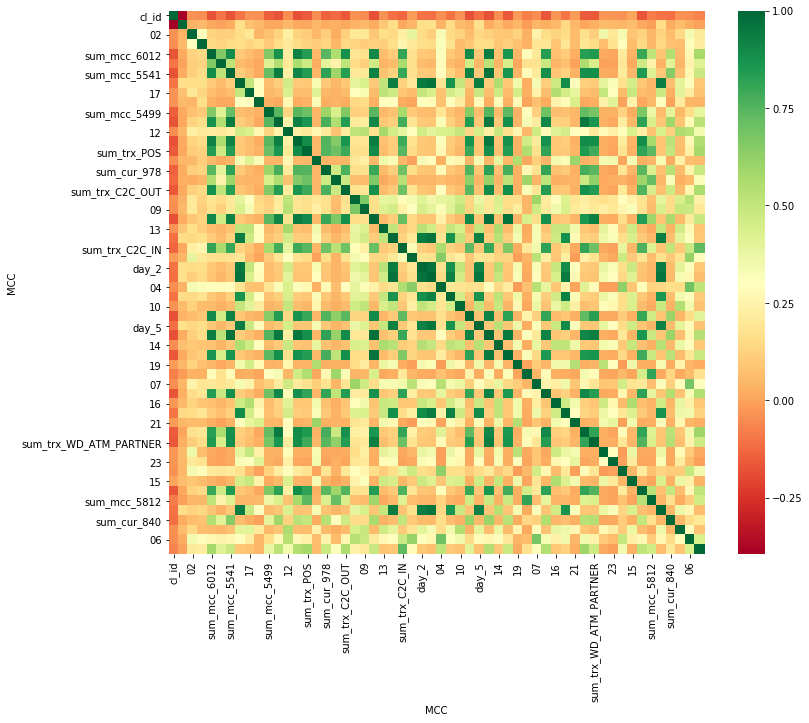

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(transactions_train.corr(),annot=False,cmap="RdYlGn");

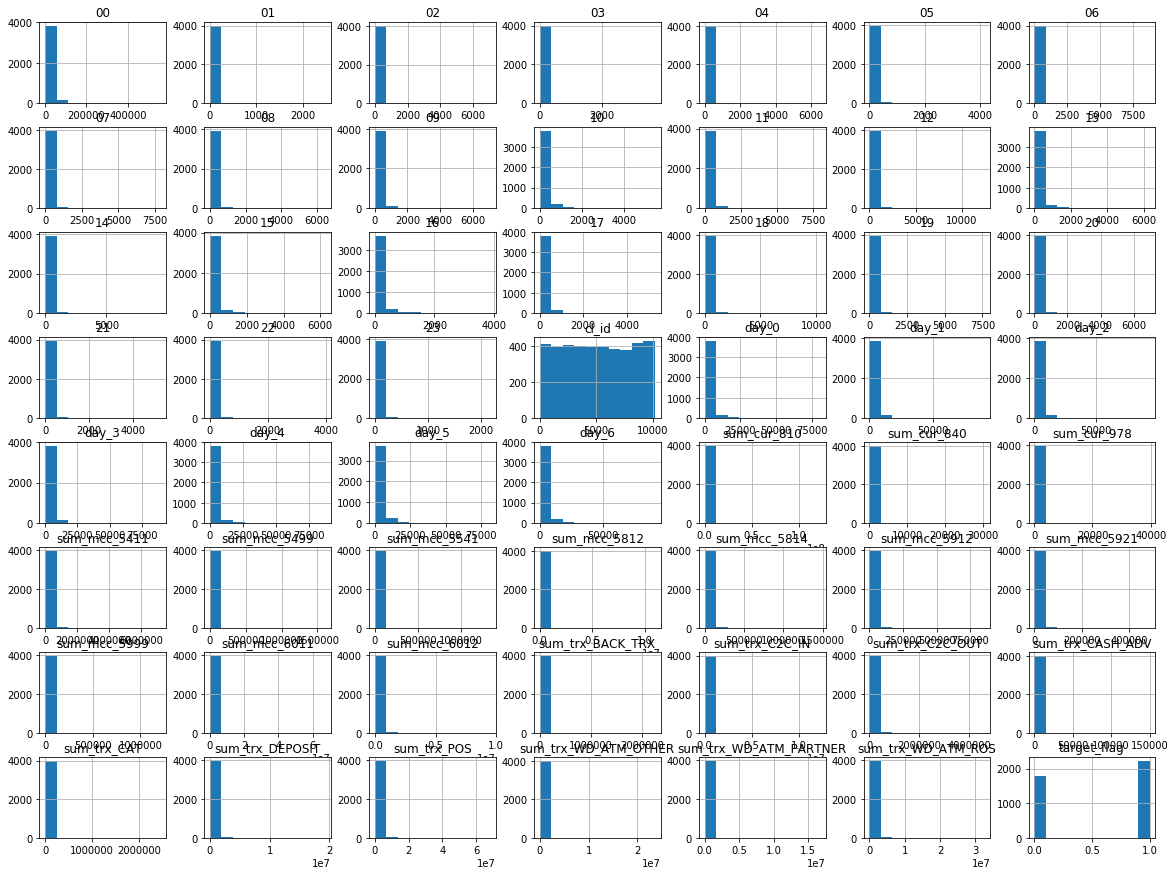

In [31]:
transactions_train.hist(figsize=(20,15));

### Построим тестовую модель на всем наборе фичей

In [32]:
x_train = transactions_train[list(set(transactions_train.columns).difference(['target_flag','channel_type']))]
y_train = transactions_train['target_flag']
x_test = transactions_test[list(set(transactions_train.columns).difference(['target_flag','channel_type']))]
y_test = transactions_test['target_flag']

xgb = xgboost.XGBClassifier(max_depth=7, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.99
Test:  0.76


In [33]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.94
Test:  0.76


In [34]:
xgb = xgboost.XGBClassifier(max_depth=6, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.97
Test:  0.76
